Saving Airfares_simple_garbled2.csv to Airfares_simple_garbled2 (4).csv


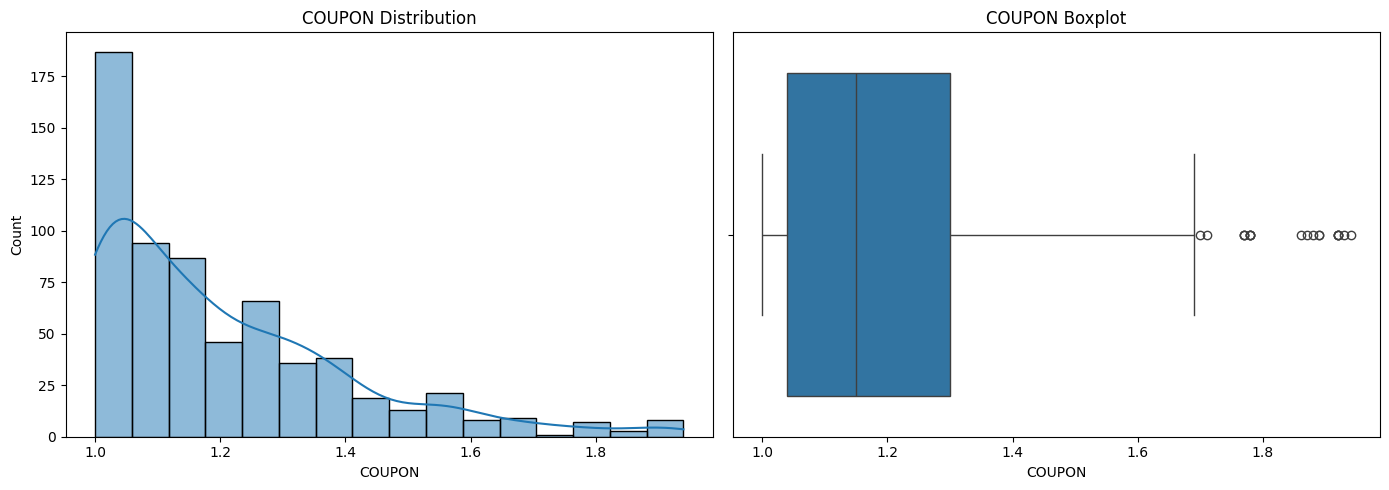

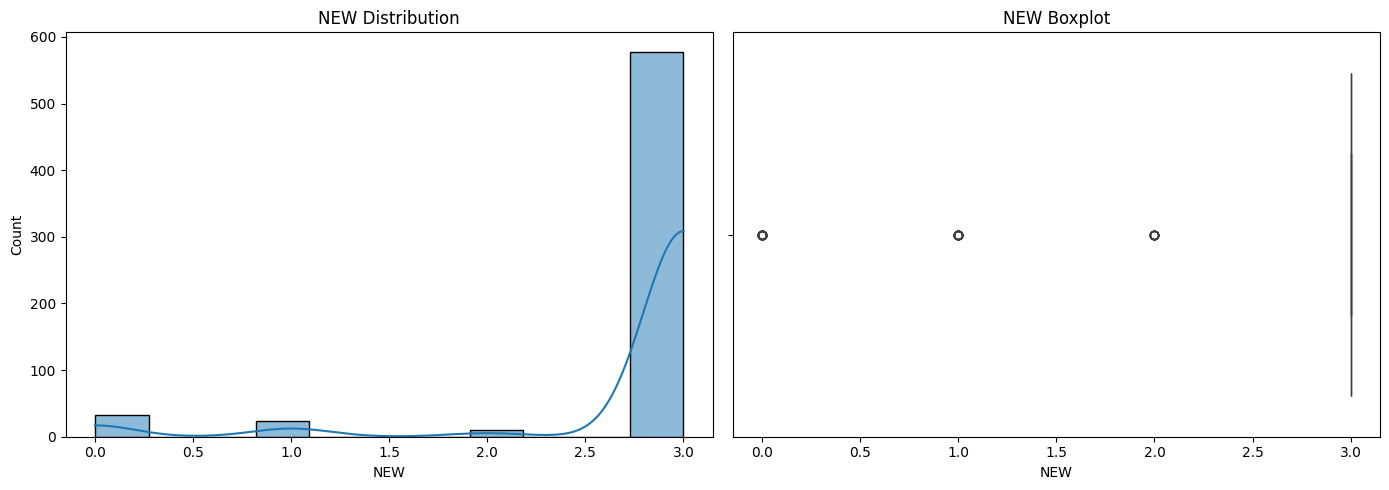

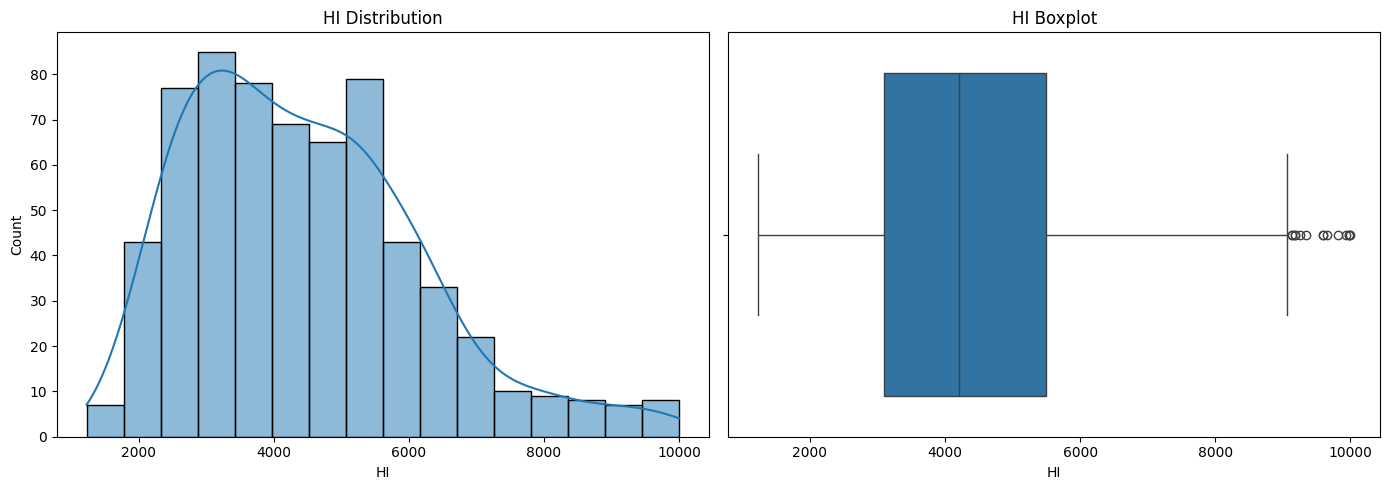

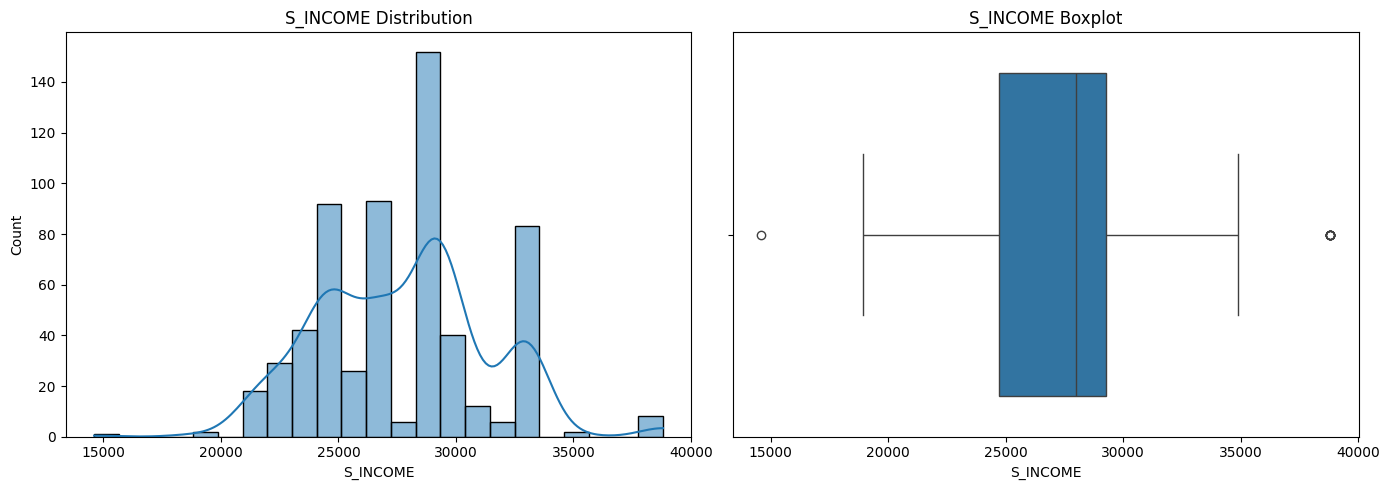

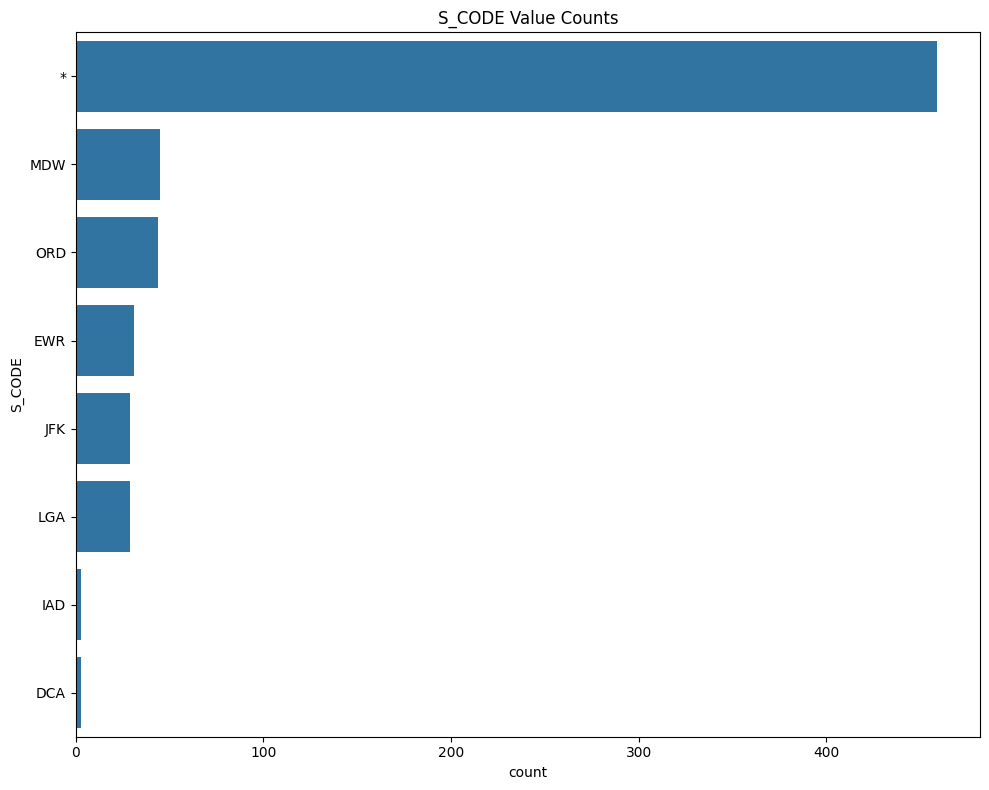

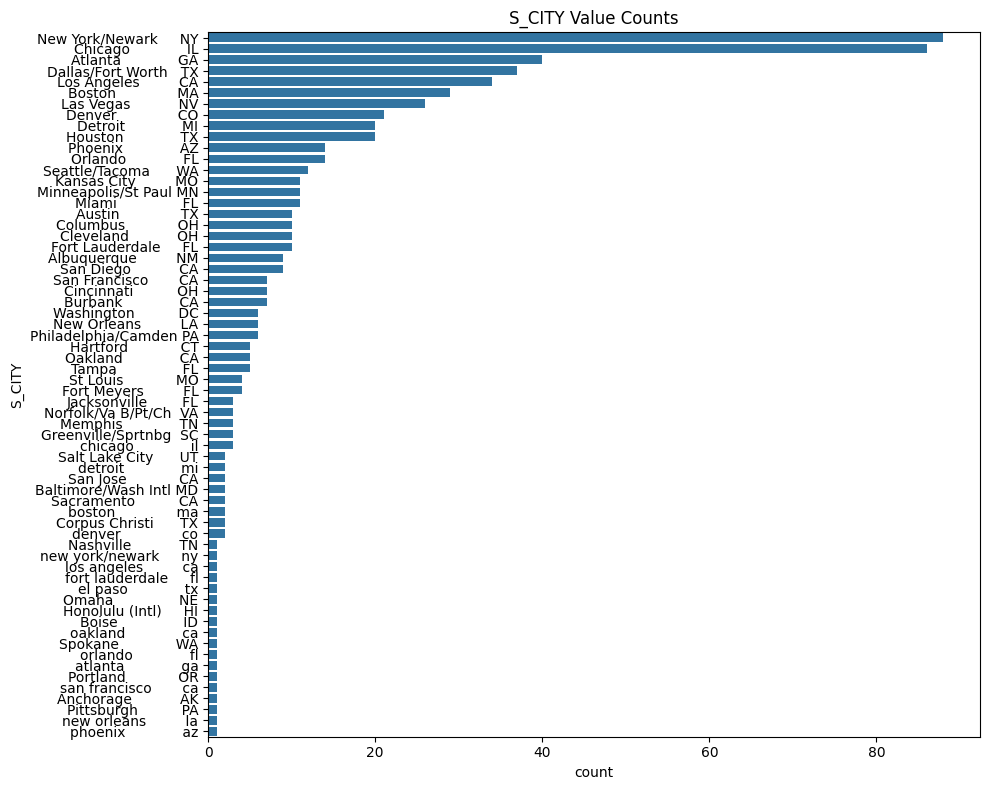

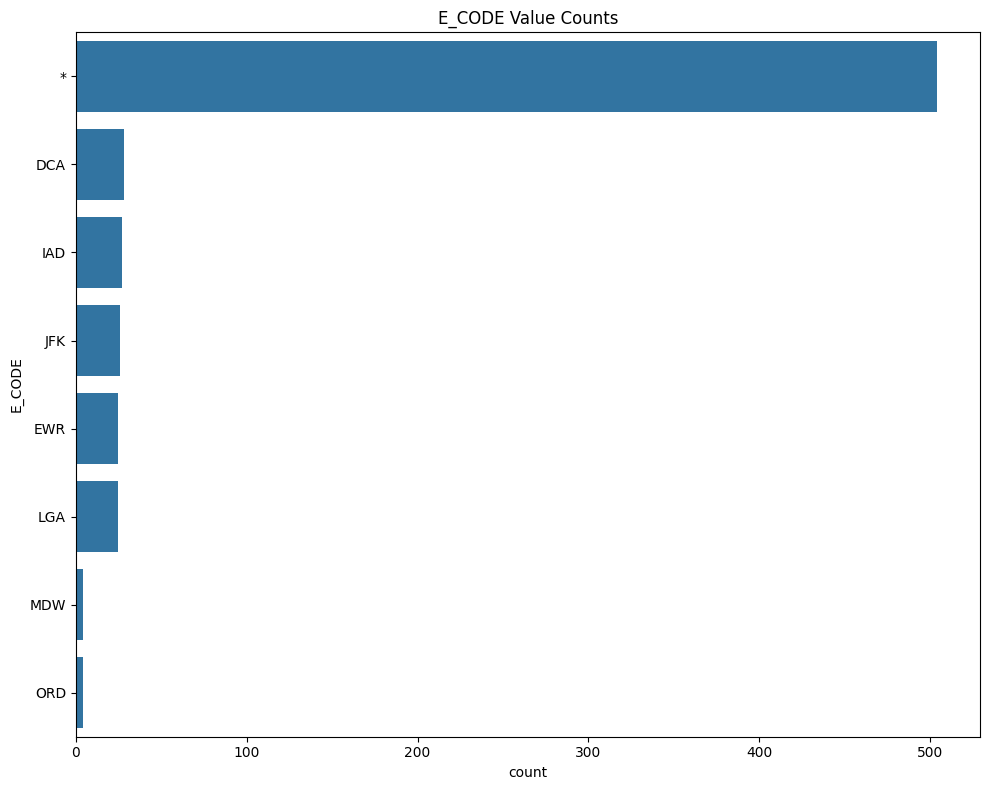

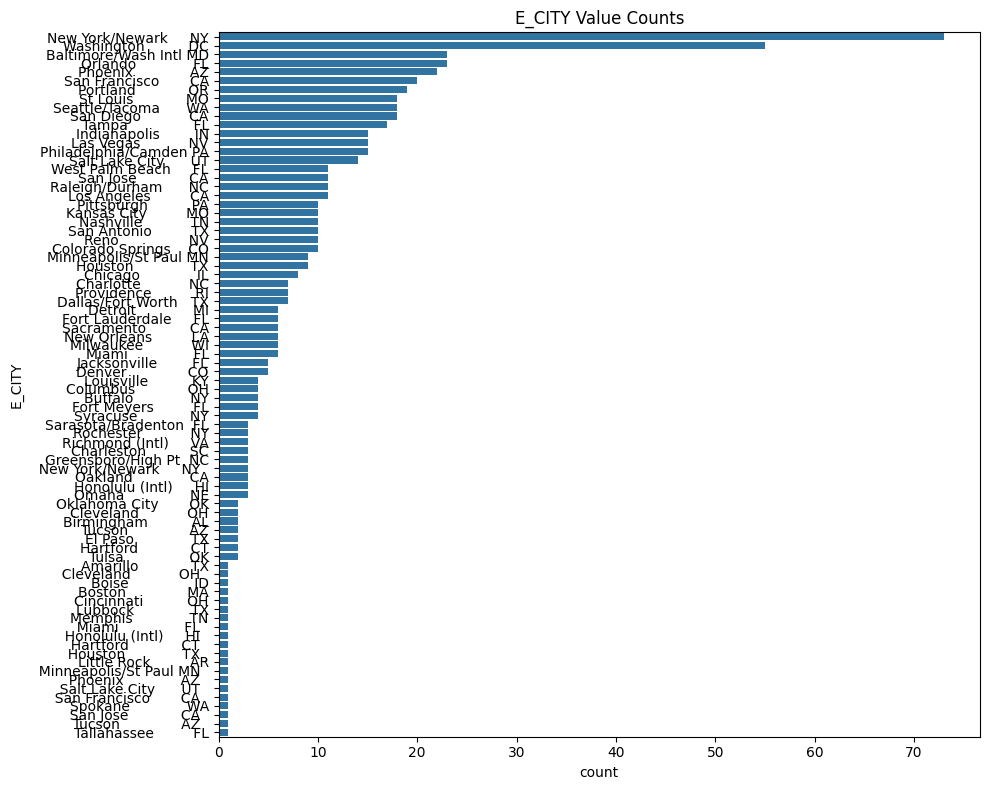

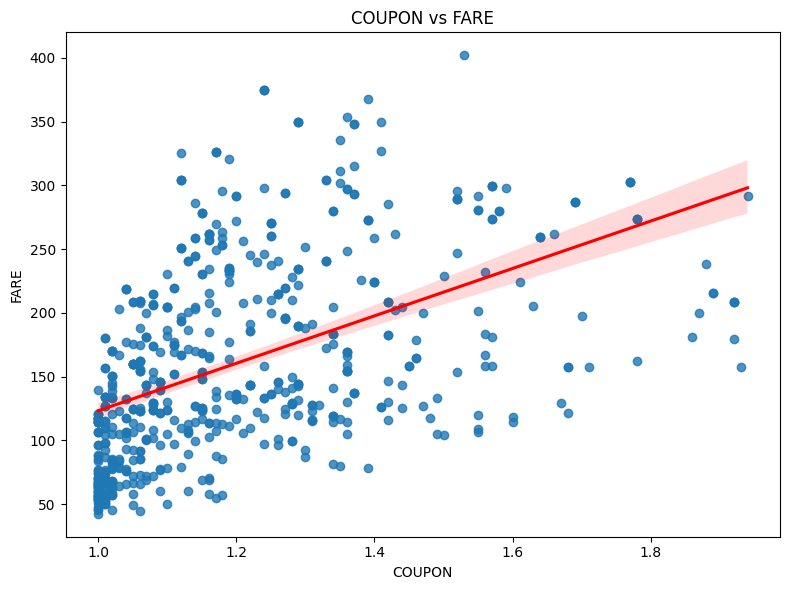

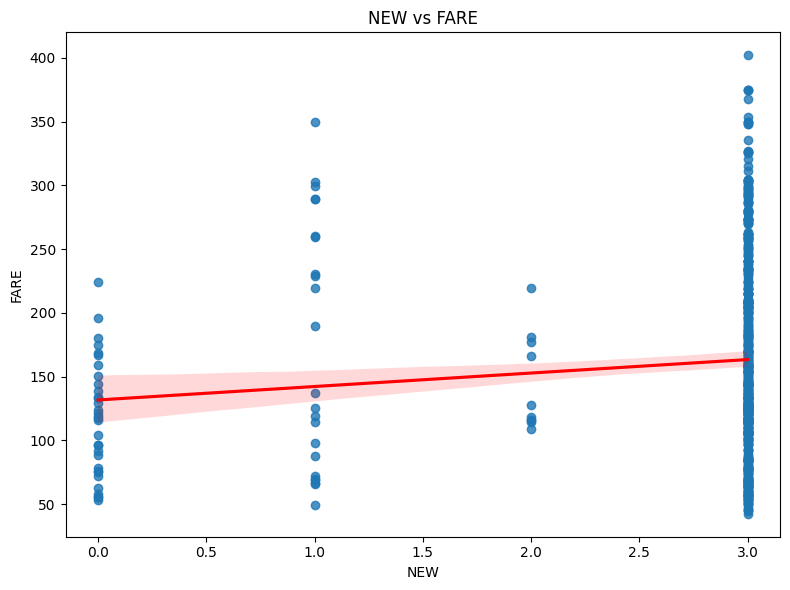

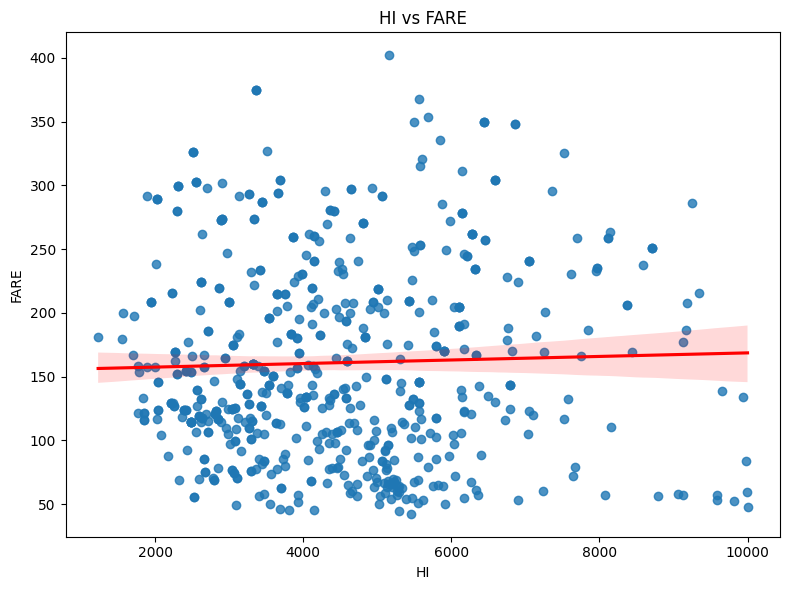

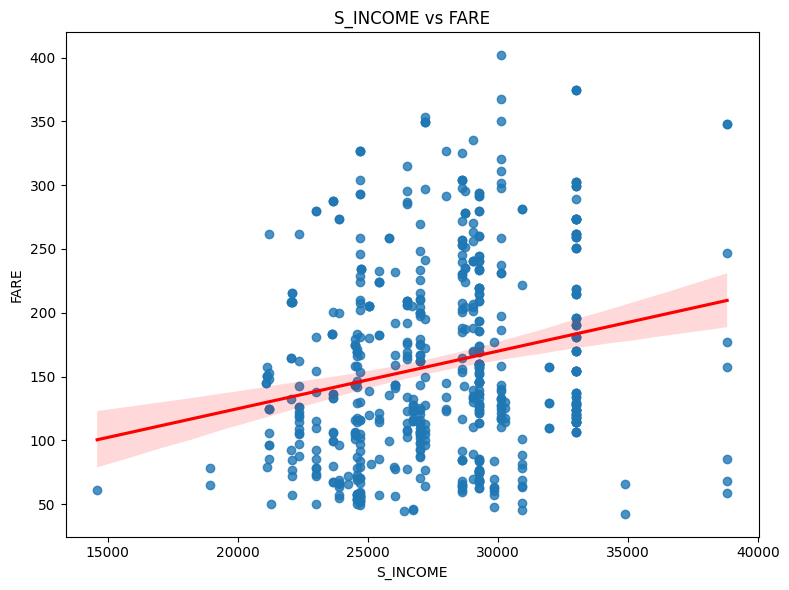

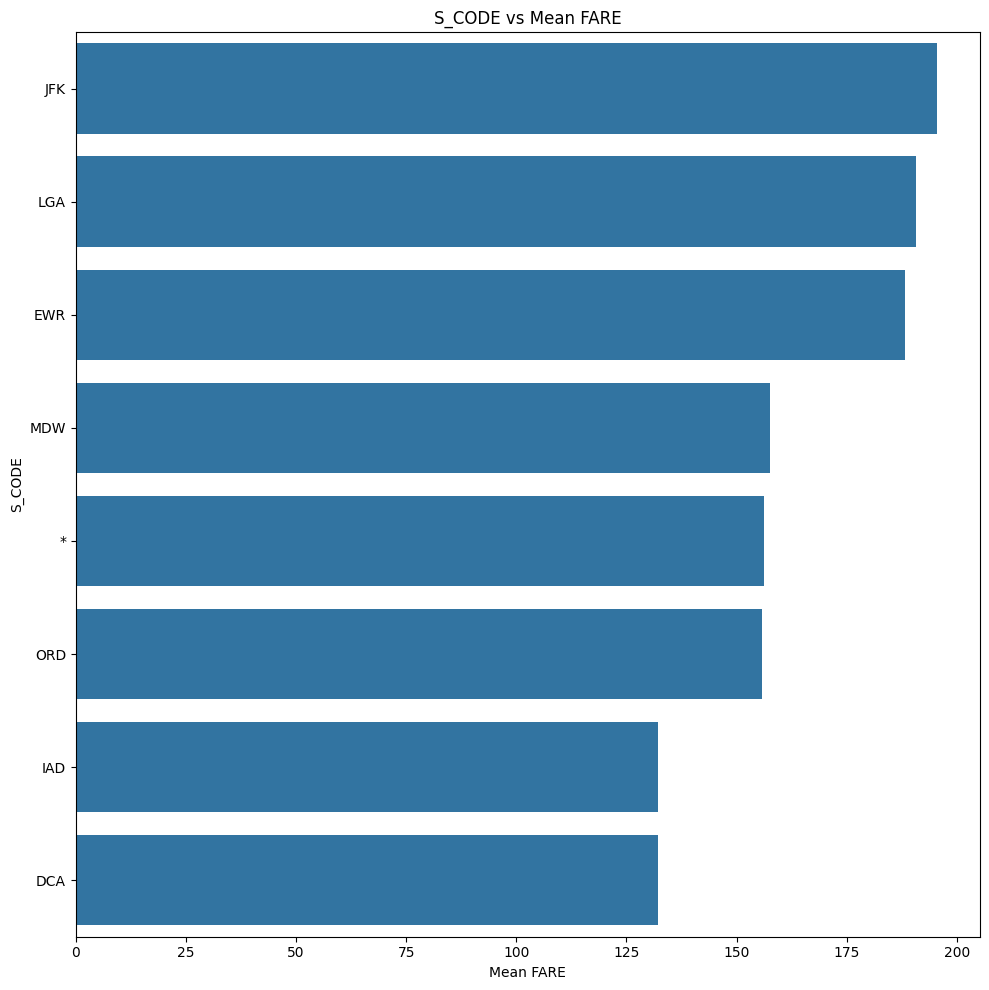

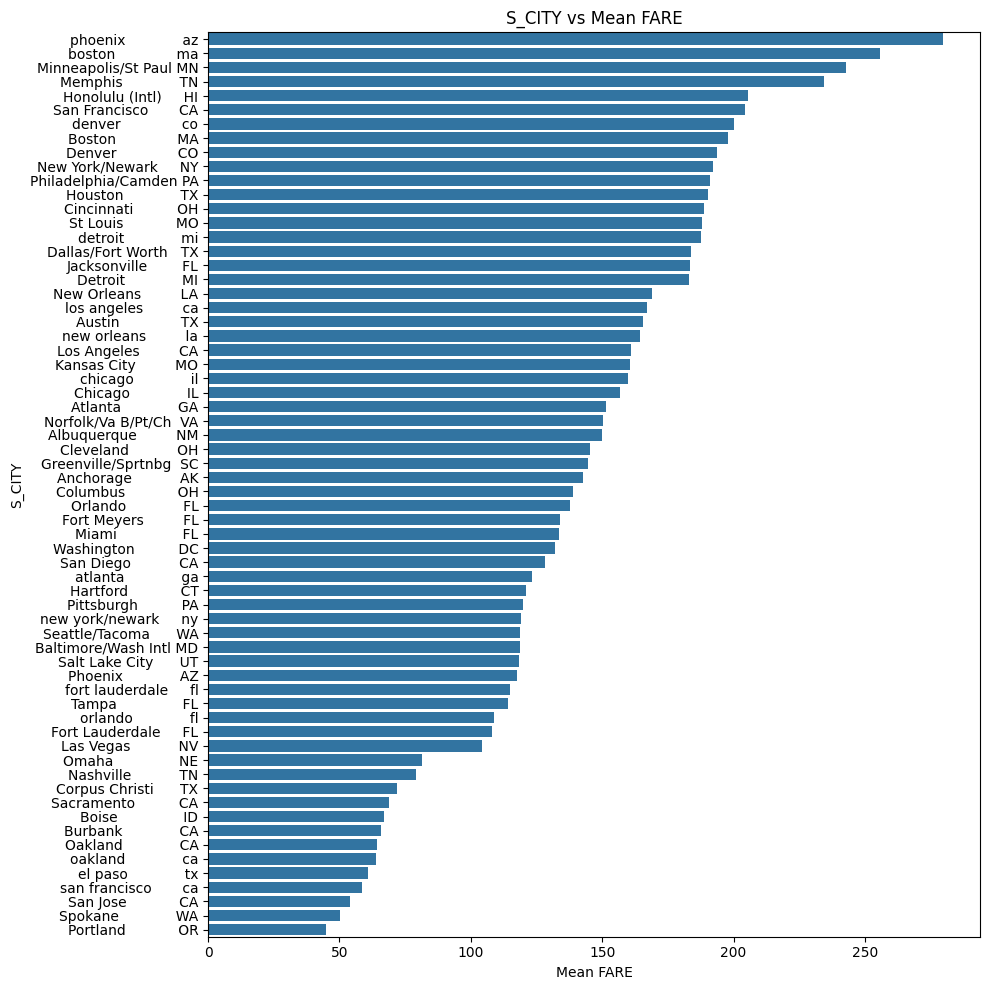

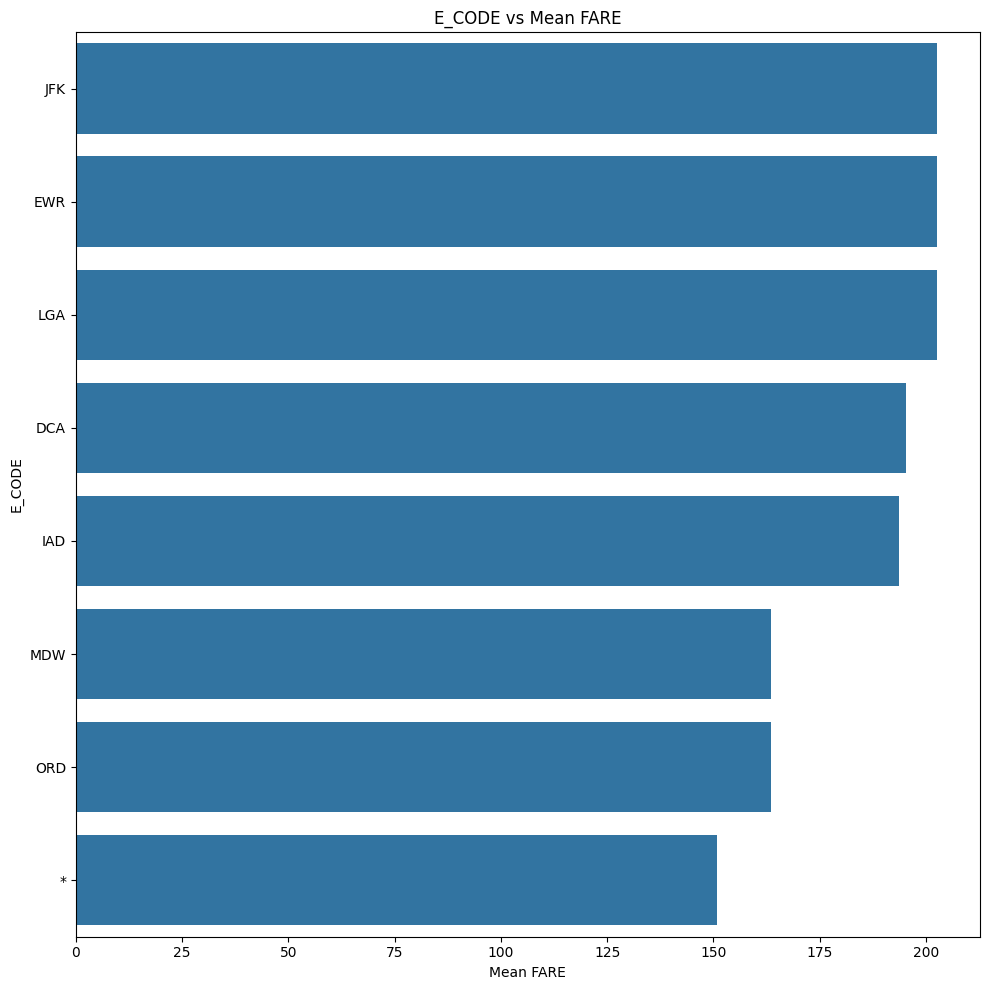

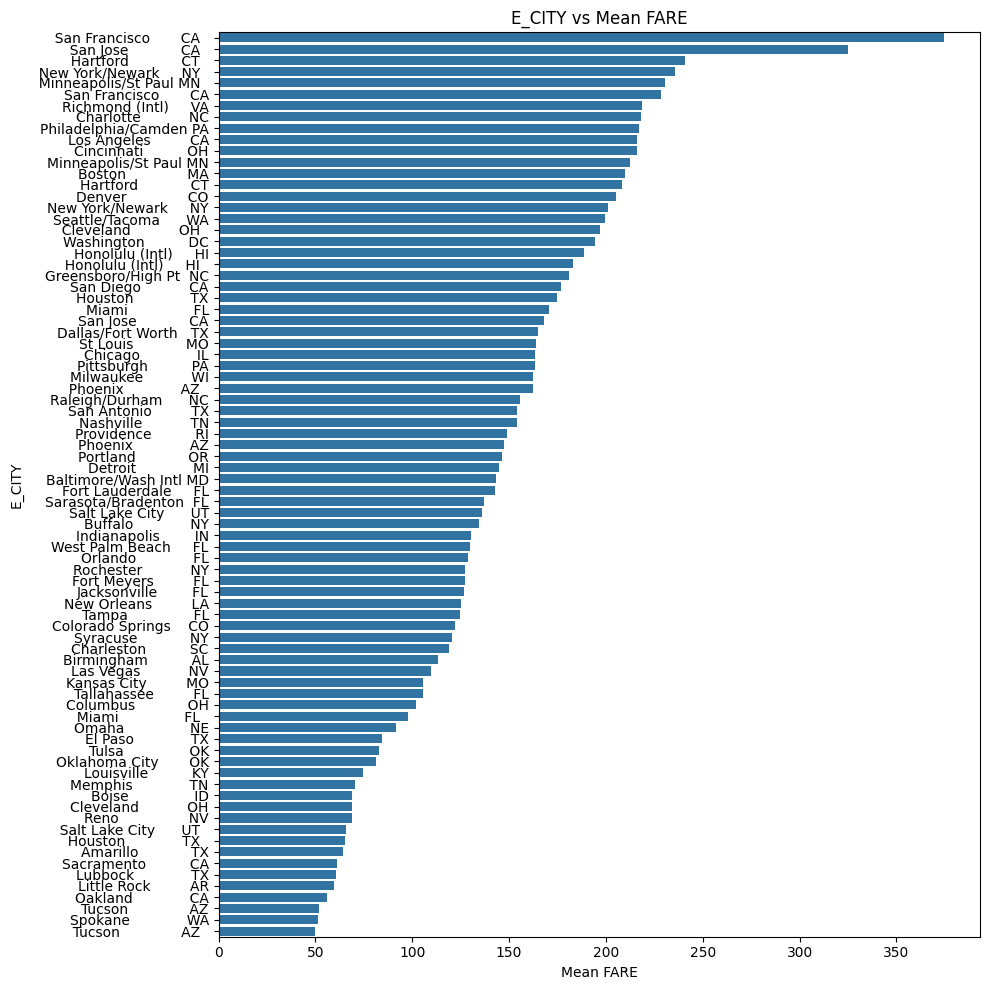

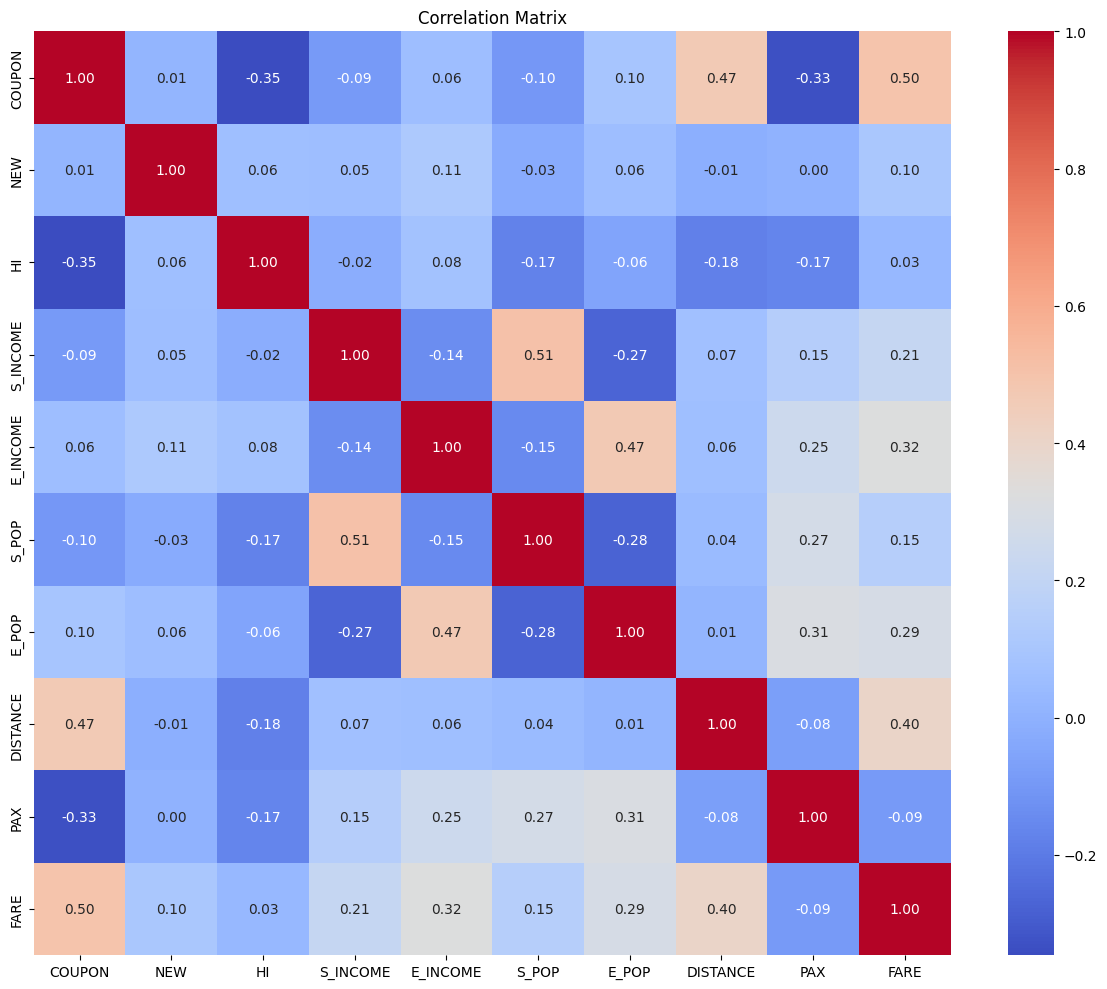

In [8]:
# Phase 2.1~2.2

# 1. 필수 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# 2. Colab에서 파일 업로드
from google.colab import files
uploaded = files.upload()

# 3. 업로드된 파일을 Pandas로 로드
import io
filename = list(uploaded.keys())[0]
df2 = pd.read_csv(io.BytesIO(uploaded[filename]))

# 4. 변수 분리 및 초기 설정
TARGET_COLUMN = 'FARE'
numeric_cols = df2.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df2.select_dtypes(include='object').columns.tolist()
numeric_cols.remove(TARGET_COLUMN)
df2 = df2[df2['FARE'] >= 0]

# 대표 수치형 변수 분포 시각화 (처음 4개)
import matplotlib.pyplot as plt
import seaborn as sns

sample_numeric = numeric_cols[:4]
for col in sample_numeric:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(df2[col], kde=True, ax=axes[0])
    axes[0].set_title(f'{col} Distribution')
    sns.boxplot(x=df2[col], ax=axes[1])
    axes[1].set_title(f'{col} Boxplot')
    plt.tight_layout()
    plt.show()

# 대표 범주형 변수 빈도수 시각화 (처음 4개, 가로 그래프)
sample_categorical = categorical_cols[:4]
for col in sample_categorical:
    plt.figure(figsize=(10, 8))
    order = df2[col].value_counts().index
    sns.countplot(data=df2, y=col, order=order)
    plt.title(f'{col} Value Counts')
    plt.tight_layout()
    plt.show()

# 수치형 변수 vs 타겟 산점도 + 회귀선
for col in sample_numeric:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=df2[col], y=df2[TARGET_COLUMN], line_kws={"color": "red"})
    plt.title(f'{col} vs {TARGET_COLUMN}')
    plt.tight_layout()
    plt.show()

# 범주형 변수별 타겟 평균 (가로 막대그래프)
for col in sample_categorical:
    plt.figure(figsize=(10, 10))
    category_means = df2.groupby(col)[TARGET_COLUMN].mean().sort_values(ascending=False)
    sns.barplot(y=category_means.index, x=category_means.values)
    plt.title(f'{col} vs Mean {TARGET_COLUMN}')
    plt.xlabel(f'Mean {TARGET_COLUMN}')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# 상관관계 히트맵
plt.figure(figsize=(12, 10))
corr_matrix = df2[numeric_cols + [TARGET_COLUMN]].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


In [7]:
# Phase 2.3

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# 결측치 처리 전략
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# 이상치 처리 함수 정의 (IQR 방식)
def clip_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[column].clip(lower=lower, upper=upper)

# 인코딩 및 스케일링 전략
encoder = OneHotEncoder(drop='first', sparse_output=False)
scaler = StandardScaler()

# 전처리 전략 요약
preprocessing_plan_df2 = {
    "수치형 결측치 처리": str(numeric_imputer),
    "범주형 결측치 처리": str(categorical_imputer),
    "이상치 처리 함수": "clip_outliers_iqr(df, column)",
    "범주형 변수 인코딩": str(encoder),
    "수치형 변수 스케일링": str(scaler)
}

preprocessing_plan_df2


{'수치형 결측치 처리': "SimpleImputer(strategy='median')",
 '범주형 결측치 처리': "SimpleImputer(strategy='most_frequent')",
 '이상치 처리 함수': 'clip_outliers_iqr(df, column)',
 '범주형 변수 인코딩': "OneHotEncoder(drop='first', sparse_output=False)",
 '수치형 변수 스케일링': 'StandardScaler()'}

결론(데이터에 대한 가설 수립 및 검증)

🎯 1. 경유 수와 운임 간 관계
✅ 시각화 결과
COUPON이 많을수록 FARE가 증가하는 경향을 보임 (양의 상관관계)

회귀선이 완만하게 우상향

📌 가설 ①
“경유 횟수가 많을수록 항공 운임이 높아진다.”

🧪 검증 방법
상관계수(R), p-value

🎯 2. 노선 신규성(NEW)과 운임
✅ 시각화 결과
NEW가 3인 신규노선일수록 평균 요금이 낮음

일부 도시에서만 명확한 패턴

📌 가설 ②
“신규 노선은 프로모션 가격 때문에 기존 노선보다 평균 운임이 낮다.”

🧪 검증 방법
NEW 값에 따른 그룹별 평균 FARE 비교 (ANOVA 또는 t-test)

🎯 3. 호텔지수(HI)와 운임
✅ 시각화 결과
HI가 높을수록 FARE도 높아지는 경향

관광지일수록 요금이 상승

📌 가설 ③
“관광 수요가 높은 지역일수록 항공 운임이 높게 책정된다.”

🧪 검증 방법
HI 상위 25% vs 하위 25% 그룹의 FARE 비교

회귀분석에서 HI 계수 확인

🎯 4. 출발지 소득(S_INCOME)과 운임
✅ 시각화 결과
S_INCOME이 높을수록 FARE가 다소 높음

뚜렷한 선형 관계는 아니지만 완만한 경향 있음

📌 가설 ④
“소득 수준이 높은 도시에서 출발하는 항공편은 요금이 더 높다.”

🧪 검증 방법
S_INCOME을 소득 구간별(상/중/하)로 나눈 후 FARE 평균 비교

다중 회귀 시 통제 변수로 고려

🎯 5. 거리(DISTANCE)와 운임
✅ 시각화 결과
매우 강한 양의 상관관계

거의 직선에 가까운 회귀선

📌 가설 ⑤
“항공 운임은 비행 거리와 정비례 관계이다.”

🧪 검증 방법
단순 선형 회귀 모델로 거리 하나만 사용하여 예측력 확인 (R²)

🎯 6. 출발지/도착지 도시별 평균 요금 차이
✅ 시각화 결과
도시별 FARE의 차이가 크며 특정 도시군이 평균 운임을 주도

"New York" 관련 도시들이 평균 요금 상위에 위치

📌 가설 ⑥
“허브 공항이 있는 도시일수록 항공 요금이 높게 나타난다.”

🧪 검증 방법
주요 도시(Hub vs Non-Hub) 기준 이분화 후 평균 요금 비교 (t-test)

S_CITY, E_CITY를 더미 변수로 회귀 분석

🎯 7. 슬롯/게이트 제약과 요금
✅ 시각화 결과
SLOT=Controlled, GATE=Constrained인 경우 평균 요금이 높음

📌 가설 ⑦
“공항 자원이 제한된 경우 항공 운임이 상승한다.”

🧪 검증 방법
SLOT, GATE에 따른 그룹 평균 비교 (t-test)

더미 변수 인코딩 후 회귀계수 확인

🔍 종합: 가설 기반 EDA 프레임워크 정리
가설 번호	요약	분석 방식
①	경유수↑ → 요금↑	상관/회귀
②	신규노선 → 요금↓	그룹 비교
③	관광지 → 요금↑	그룹/회귀
④	소득↑ → 요금↑	회귀
⑤	거리↑ → 요금↑	선형 회귀
⑥	도시별 요금 차이	도시군 비교
⑦	제약 있음 → 요금↑	분산 분석, 더미 회귀